In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
import control
import scipy.integrate
import sympy_utils
import scipy.linalg
import sympy
from IPython.display import Latex
rcParams['font.size']=15
rcParams['figure.figsize']=(10,5)

Populating the interactive namespace from numpy and matplotlib


# Continuous Time Theory

We consider the following linear system:

\begin{align*}
\dot{x} &= Ax + Bu + w\\
u &= -K\hat{x} \\
\dot{\hat{x}} &= (A - BK) \hat{x} + L (y - C\hat{x})\\
y &= Cx + v + d\\
\end{align*}

where $(v,w)$ are white noise with covariance given by ($Q$, $R$) and $d$ is the sensor attack vector.


The error dynamics are given by:

\begin{align*}
e &\equiv \hat{x} - x\\
\dot{e} &= (A - LC) e + Lv + L d - w\\
\end{align*}

The system residual that is used for detecting a fault is the difference between the true and expected measurement:

$$ r \equiv y - C \hat{x} $$

We can write the error dynamics in terms of the system residual as:
\begin{align*}
\dot{e} &= (A - LC) e + Lv + L(r + Ce - v) - w\\
\dot{e} &= Ae + Lr -w
\end{align*}

A quadratic Lyapunov function can be constructed for the estimator error:

\begin{align*}
V(e) &= e^T P e\\
\dot{V} &= \frac{\partial V}{\partial e} \frac{d e}{dt} = 2 e^T P [(A - LC) e + Lv + Ld - w]\\
\dot{V} &= 2 e^T P [ (A - LC) e + Lv + L(r + Ce - v) -w]\\
\dot{V} &= 2 e^T P [ Ae + Lr - w]
\end{align*}

We want to maximize the growth of the Lyapunov function to destabilize the system while not being detected so we ensure that the sensor attack does not cause a fualt to be detected by maintaining a low residual, $r$. This problem can be restated as finding the worst case residual on the fault detection ellipsoid and then later computing the attack vector, $d$, that results in that residual.


\begin{align*}
\text{maximize:}\\
\dot{V}(r) &\equiv 2e^TP[Ae + Lr - w]\\
\\
\text{subject to:}\\
\\
g(r) &\equiv r^T S r - \beta^2 < 0 \\
\end{align*}

where the innovation covariance $S$ is equal to $R$ for a continuous time observer.

We can solve this problem using Lagrange multipliers. The maximum and minimum points will occur when the gradient of the constraint, and the gradient of the Covariance ellipsoid are parallel (KKT stationarity condition):

\begin{align*}
\nabla \dot{V}(r^*) = \lambda \nabla g(r^*) \\
2e^TPL =  \lambda 2r^{*T}S\\
\end{align*}

We can solve this expression for $r$ to find:
\begin{align*}
r^* =  S^{-1}L^TPe / \lambda
\end{align*}

The final step is to find the intersection of the Lyapunov gradient and bounding residual ellipsoid.

\begin{align*}
\hat{r} &\equiv \frac{ S^{-1}L^TPe}{| S^{-1}L^TPe|} \\
d^* &= Ce + \hat{r} \left(\beta_{max} / \sqrt{\hat{r} S \hat{r}^T}\right)
\end{align*}

This assumes that we know $e$ exactly. In the case that this information is not avaialbe, it could be estimated from observations of the system.

This can be considered a locally optimal controller for the cost function:

$$J = \int_0^T -\dot{V}(e) dt = -V_F$$

where $V_F$ is the Lyapunov funtion at the final time.

In order to prove global optimality, it would be necessary to propagate backward in time, but the final state is not known. It might be able to prove global optimality for a subset of problems.

# Discrete Time Theory

Dynamics:

\begin{align*}
x_2 &= A x_1 + B u + w\\
u &= -K \hat{x}_1\\
x_2 &= A x_1  - BK \hat{x}_1 + w\\
\hat{x}_2 &= (A - BK)\hat{x}_1 + Lr\\
e_2 &= \hat{x}_2 - x = A e_1 + Lr - w\\
V_2 &= e_2^T P e_2 \\
\end{align*}

Statement of optimization problem:
\begin{align*}
\text{maximize}:\\
V_2(r) &= e_2^T P e_2 \\
\text{subject to}:\\
g(r) &= r^TSr < \beta^2
\end{align*}

Solve using Lagrange multipliers.
\begin{align*}
\frac{\partial V_2}{\partial r} &= \lambda \frac{\partial g(r)}{\partial r}\\
\frac{\partial V_2}{\partial r} &= \frac{\partial V_2}{\partial e_2} \frac{\partial e_2}{\partial r} = 2e_2^T P L = 2 (Lr + e)^T P L \\ &= 2 (r^TL^TPL + e^TPL)\\
\frac{\partial g(r)}{\partial r} &= 2r^TS\\
\lambda r^TS &= r^TL^TPL + e^TPL\\
r &= (\lambda S - L^TPL)^{-1}L^TPe
\end{align*}

Here again, $\lambda$ is chosen so that the residual is on the surface of the fault detection ellipse.

# System Definition

First we define the linear system. This is an linear approximation of a pendulum around the stable equilibrium point.

In [2]:
A = array([[0,1], [-9.8,0]])
B = array([[0], [1]])
C = eye(2)
D = zeros((2,1))
ss_open = control.ss(A,B,C,D)
sympy_utils.show_latex(sympy_utils.ss_to_latex(ss_open))

# Controller Design

Now we implement a linear quadratic regulator.

In [3]:
K = control.lqr(A, B, np.eye(2), np.eye(1))[0]
K

array([[ 0.05088828,  1.04965545]])

In [4]:
sympy_utils.show_latex('K='+sympy_utils.matrix_to_latex(K))

In [5]:
eig(A - B.dot(K))[0]

array([-0.52482773+3.09442146j, -0.52482773-3.09442146j])

# Observer Design

Next, we solve for the steady state Kalman filter gain, L.

In [6]:
process_noise_power = array([0.001, 0.001])
measurement_noise_power = array([0.01, 0.02])
dt = 0.01

Q = diag((process_noise_power/dt))
R = diag((measurement_noise_power/dt))

P, E, L = control.care(A=A.T, B=C.T, Q=Q, R=R)

/home/jgoppert/.virtualenvs/dev/local/lib/python2.7/site-packages/control/mateqn.py:461: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if R != None and len(shape(R)) == 1:
/home/jgoppert/.virtualenvs/dev/local/lib/python2.7/site-packages/control/mateqn.py:480: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if R==None:


In [7]:
sympy_utils.show_latex('Q='+sympy_utils.matrix_to_latex(Q))

In [8]:
sympy_utils.show_latex('R='+sympy_utils.matrix_to_latex(R))

In [9]:
sympy_utils.show_latex('L='+sympy_utils.matrix_to_latex(L))

We verify that the observer dynamics are stable.

In [10]:
eig(A - L.dot(C))[0]

array([-0.40139658+3.17835749j, -0.40139658-3.17835749j])

We verify that this Kalman observer satisfies the steady state algebraic ricatti equation.

In [11]:
A.dot(P) + P.dot(A.T) + Q - L.dot(R).dot(L.T)

array([[-0.00239638,  0.02376664],
       [ 0.02376664,  0.00119819]])

# Combined Dynamics

We create a combined system using the separation principle with the state and error dynamcis.

In [12]:
Ap = bmat([[A-B.dot(K), B.dot(K)], [zeros((2,2)), A-L.dot(C)]])
Bp = bmat([[zeros((2,2))],[L]])
Cp = bmat([[C, zeros((2,2))]])
Dp = zeros((2,2))
ss_combined = control.ss(Ap,Bp,Cp,Dp)
sympy_utils.show_latex(sympy_utils.ss_to_latex(ss_combined, subscript='_o', newline=True))

# Lyapunov Function

We solve the continuous time Lyapunov equation $A_oP + PA_o^T + Q = 0$ where $A_o = A - LC$, for $P$. The Lyapunov function is given by $V(e) = e^T P e$ and the Lyapunov equation where $Q$ is positive definite reprsents the assertion that the observer is stable.

In [13]:
Ao = A - L.dot(C)
P_lyap = scipy.linalg.solve_lyapunov(Ao.T, -np.eye(2))
sympy_utils.show_latex('P='+sympy_utils.matrix_to_latex(P))

In [14]:
Ao.T.dot(P_lyap) + P_lyap.dot(Ao) + eye(2)

array([[ -2.22044605e-15,   2.66453526e-15],
       [  2.66453526e-15,   2.22044605e-16]])

# Code

In [15]:
def ss_to_sim_f(ss):
    """
    A function to create simulation
    functions for scipy using a state space.
    """
    f_x_dot = lambda t, x, u, w: ss.A.dot(x) + ss.B.dot(u) + w
    f_y = lambda t, x, u, v: ss.C.dot(x) + ss.D.dot(u) + v
    return f_x_dot, f_y

In [16]:
def sim(ss, x0, f_u, dt, tf):
    """
    A simulation for a state space system
    with a feedback control law.
    """
    
    f_x_dot, f_y = ss_to_sim_f(ss)
    ode = scipy.integrate.ode(f_x_dot)
    ode.set_initial_value(x0)
    x = []
    y = []
    t = []
    u = []
    while ode.t < tf:
        x.append(ode.y)
        t.append(ode.t)
        u_i = f_u(t, ode.y)
        u.append(u_i)
        
        v = measurement_noise_power*randn(2)/dt
        y.append(np.array(f_y(ode.t, ode.y, u_i, v))[0])
        
        w = process_noise_power*randn(2)/dt
        w = np.hstack([w, [0,0]])
        ode.set_f_params(u_i, w)
        
        ode.integrate(ode.t + dt)

    x = array(x)
    y = array(y)
    t = array(t)
    u = array(u)
    return t, y, x, u

In [17]:
def ellipse(P):
    U, S, V = svd(P)
    C = array([[cos(theta), sin(theta)]
                  for theta in np.linspace(0,2*pi)])
    return C.dot(U.dot(diag(1.0/sqrt(S))).dot(V))

## Lyapunov Gradient Attack Strategy

In [18]:
def f_u(t, xp, u_norm_max, beta_max):
    """
    The lyapunov gradient attack strategy.
    """
    x = array([xp[:2]]).T # state
    e = array([xp[2:]]).T # error
    
    # optimal residual direction
    S = R
    r_dir = inv(S).dot(L.T).dot(P).dot(e)
    r_norm = norm(r_dir)
    if r_norm <= 0:
        r_dir = np.array([1,0]).T
    else:
        r_dir = r_dir/r_norm

    # find fault detection threshold
    # for scaling gradient vector
    beta_scaling = beta_max/sqrt(r_dir.T.dot(S).dot(r_dir))
    
    # create attack
    u = C.dot(e) + r_dir*beta_scaling
    
    # prevent attack from exceeding bound
    u_norm = norm(u)
    if u_norm > u_norm_max:
        u = u*u_norm_max/u_norm
    return u[:,0]

In [19]:
def plot_sensor_attack(t, y, x, u):
    figure()
    plot(t, u);
    #title('sensor attack input')
    xlabel('t')
    ylabel(r'attack')
    grid();

In [20]:
def plot_estimator_error(t, y, x, u):
    figure()
    plot(t, x[:,2]);
    #title(r'estimation error in $\theta$')
    xlabel('t')
    ylabel(r'$\theta$')
    grid();

In [21]:
def plot_fault_detection(t, y, x, u):
    figure()
    e = x[:,2:].T
    r = u - C.dot(e).T
    beta = np.sqrt(
        array([r_i.T.dot(R).dot(r_i) for r_i in r]))
    plot(t, beta);
    #title('fault detection threshold')
    xlabel('t')
    ylabel(r'$\beta$')
    grid()
    axis([t[0], t[-1], 0, 1.1*max(beta)]);

In [22]:
def plot_phase_plane(t, y, x, u):
    figure()
    plot(x[:,2], x[:,3], 'k');
    grid()
    e2 = ellipse(P_lyap)
    for d in arange(0,2,0.5):
        plot(d*e2[:,0], d*e2[:,1], 'r--')

    #title('phase plane')
    xlabel(r'$\theta$')
    ylabel(r'$\dot{\theta}$');
    legend(['x', 'V'], loc='best');

In [23]:
def plot_lyapunov(t, y, x, u):
    figure()
    V = array(
        [x_i.T.dot(P_lyap).dot(x_i) for x_i in x[:,2:]])
    plot(t, V)
    xlabel('t')
    ylabel('V')
    #title('Lyapunov function growth');
    grid();
    return V

In [24]:
def plot_all(t, y, x, u):
    plot_sensor_attack(t, y, x, u)
    plot_estimator_error(t, y, x, u)
    plot_fault_detection(t, y, x, u)
    plot_phase_plane(t, y, x, u)
    plot_lyapunov(t, y, x, u)

# Simulation Results

In [25]:
t, y, x, u = sim(
    ss=ss_combined,
    x0=[0.1,0.1,0.1,0.1],
    f_u = lambda t, xp: f_u(t=t, xp=xp, u_norm_max=1000, beta_max=1),
    dt=0.01,
    tf=10)

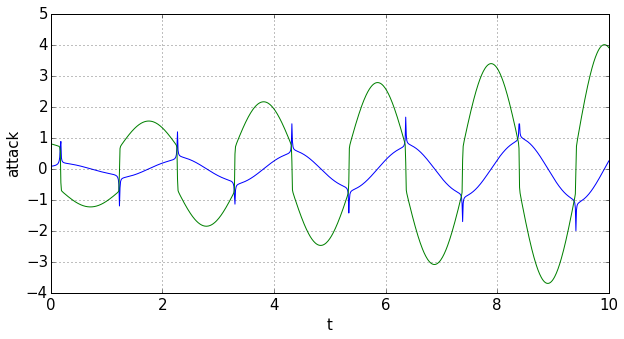

In [26]:
plot_sensor_attack(t, y, x, u)
savefig(os.path.join('figures','cont-sensor-attack-input.pdf'))

The generated attack signals are complicated and are not sinusoids.

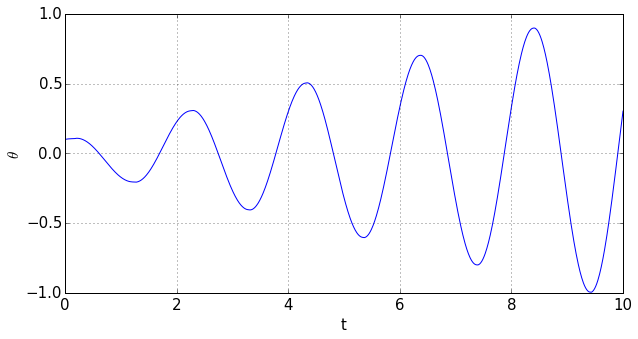

In [27]:
plot_estimator_error(t, y, x, u)
savefig(os.path.join('figures','cont-est-error.pdf'))

We can successfully destabilize the system.

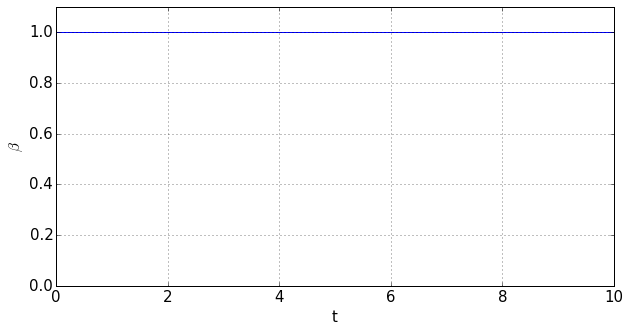

In [28]:
plot_fault_detection(t, y, x, u)
savefig(os.path.join('figures','cont-fault-detection-threshold.pdf'))

We set $\beta_{max}$ so that it is unlikely that $\beta$ will exceed the threshold required to trigger a fault.

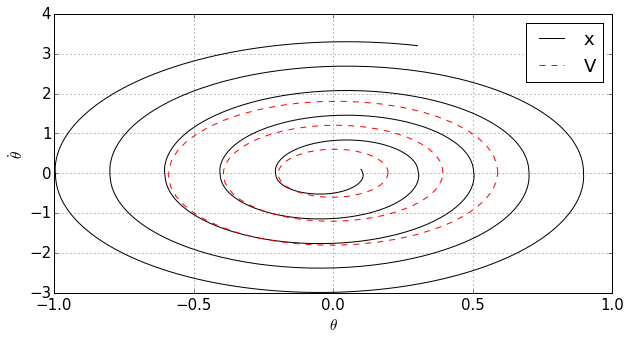

In [29]:
plot_phase_plane(t, y, x, u)
savefig(os.path.join('figures','cont-phase-plot.pdf'))

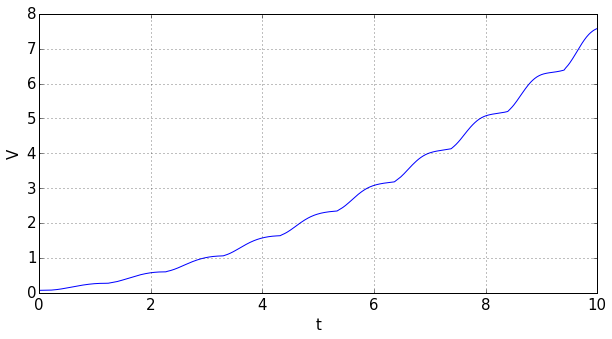

In [30]:
V = plot_lyapunov(t, y, x, u)
savefig(os.path.join('figures','cont-lyap-growth.pdf'))

The Lyapunov function evolution is not necessarily monotonically increasing since the attack magnitude is limited.

The overall performance of the attack can be judged using the final value of the Lyapunov function.

In [31]:
print 'final value of Lyapunov function: ', V[-1]

final value of Lyapunov function:  7.57671083456


# Attack Saturation

This is suboptimal, the attack saturatioin constraint has not been included in the optimization, the output is just limited.

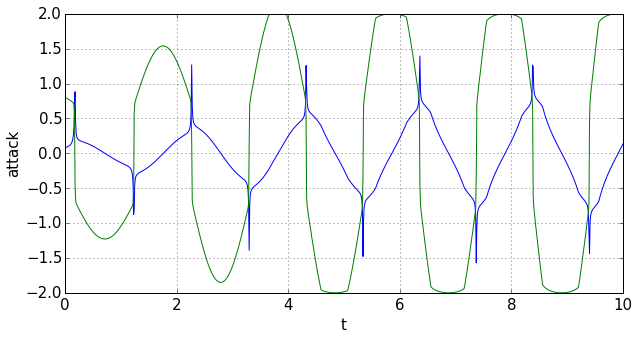

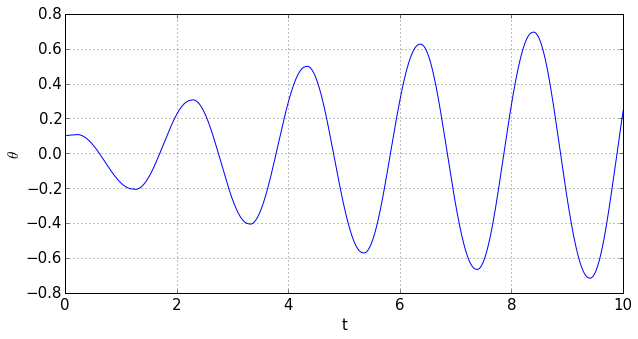

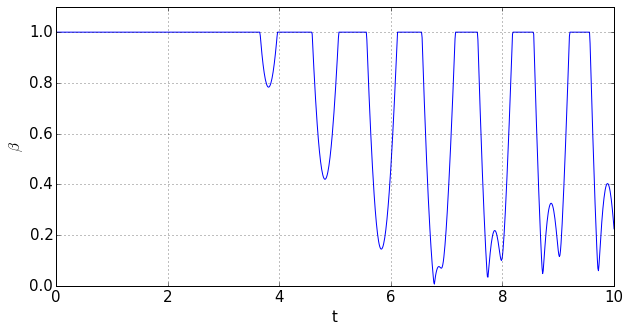

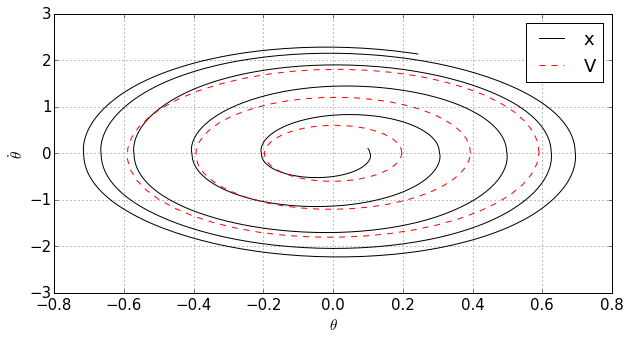

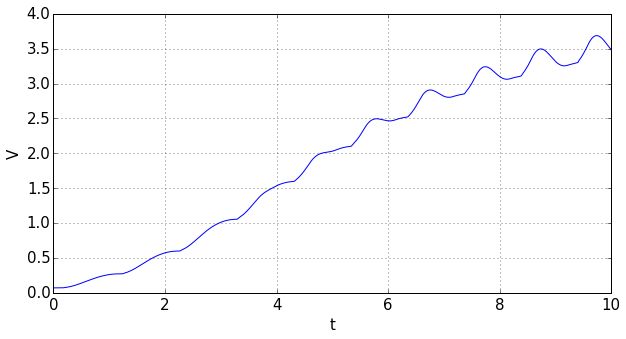

In [32]:
t2, y2, x2, u2 = sim(
    ss=ss_combined,
    x0=[0.1,0.1,0.1,0.1],
    f_u = lambda t, xp: f_u(t=t, xp=xp, u_norm_max=2, beta_max=1),
    dt=0.01,
    tf=10)

plot_all(t2, y2, x2, u2)

# Conclusions

Summary

* Method shown effective for generic controller/observer linear systems
* Can generalize to higher dimensions
* Analytical expression for locally optimal increase in Lyapunov function is efficient to compute:
\begin{align*}
\hat{r} &\equiv \frac{ S^{-1}L^TPe}{| S^{-1}L^TPe|} \\
d^* &= Ce + \hat{r} \left(\beta_{max} / \sqrt{\hat{r} S \hat{r}^T}\right)
\end{align*}

Future Directions

* Include other types of attack (actuators etc.)
* Test application to non-linear systems via linearization.
* Prove global optimality for a subset of problems for the cost function: $J = \int_0^T -\dot{V}(e) dt = -V_F$

In [33]:
%%bash
#./to_slides.sh "James Goppert" \
#"10/31/14" "Lyapunov Cyber Attack" \
#Lyapunov\ Cyber\ Attack.ipynb